https://data.humdata.org/dataset/landslide-mudslide-impact-in-mai-mahiu-and-kijabe-towns-kenya-as-of-1-may-2024

In [13]:
import geopandas as gpd
import pandas as pd
import yaml
from rasterio.crs import CRS
from pathlib import Path
import fiona
from shapely.ops import polygonize
from shapely.geometry import mapping, Polygon, shape
import glob
import fiona

In [2]:
yaml_file = '../events/mai_mahiu_flood_and_landslides_2024.yml' #'porto_algre.yml'
with open(yaml_file) as f:
    event_dict = yaml.safe_load(f)["event"]
event_dict

{'event_name': 'mai_mahiu_flood_and_landslides_2024',
 'bounds': [36.56645031, -1.32126631, 37.13272135, -0.92335618],
 'event_date': '2024-04-29',
 'pre_event_window_days': 100,
 'post_event_window_days': 60,
 'rtc_track_numbers': [130, 57],
 'mgrs_tiles': ['37MBU'],
 'dist_hls_confirmed_change_min_days': 30,
 'source_id': 'UNOSAT via humanitarian data exchange - Pléiades image',
 'links': ['https://data.humdata.org/dataset/landslide-mudslide-impact-in-mai-mahiu-and-kijabe-towns-kenya-as-of-1-may-2024',
  'https://eos.org/thelandslideblog/mai-mahiu']}

In [4]:
paths = ['../external_validation_data/unosat/mai_mahui_flood_and_landslides/FL20240426KEN_SHP/PL_20240501_LandslideMudslideExtent_MaiMahiu.shp', 
         '../external_validation_data/unosat/mai_mahui_flood_and_landslides/FL20240426KEN_SHP/PL_20240501_FloodExtent_Nairobi_Kiambu.shp'
         ]


In [5]:
dfs = [gpd.read_file(p).to_crs(4326)[['geometry']] for p in paths]
df_event = pd.concat(dfs, axis=0)
df_event.head()

,geometry
0,"MULTIPOLYGON (((36.57978 -0.98891, 36.57977 -0..."
0,"MULTIPOLYGON (((37.06500 -1.31769, 37.06500 -1..."


In [6]:
df_event.total_bounds

array([36.56645031, -1.32126631, 37.13272135, -0.92335618])

In [7]:
# df_flood_coastal = df_flood.cx[89.2:91, 21.5: 24].reset_index(drop=True)
# df_flood_coastal.explore()

In [8]:
n = df_event.shape[0]
df_event_f = gpd.GeoDataFrame({'name': [event_dict['event_name'] for k in range(n)],
                               'date': [pd.to_datetime(event_dict['event_date']) for k in range(n)],
                               'source_id': [f'{event_dict["source_id"]}' for k in range(n)]},
                              geometry=df_event.geometry.tolist(),
                              crs=CRS.from_epsg(4326))
df_event_f.head()

,name,date,source_id,geometry
0,mai_mahiu_flood_and_landslides_2024,2024-04-29,UNOSAT via humanitarian data exchange - Pléiad...,"MULTIPOLYGON (((36.57978 -0.98891, 36.57977 -0..."
1,mai_mahiu_flood_and_landslides_2024,2024-04-29,UNOSAT via humanitarian data exchange - Pléiad...,"MULTIPOLYGON (((37.06500 -1.31769, 37.06500 -1..."


<Axes: >

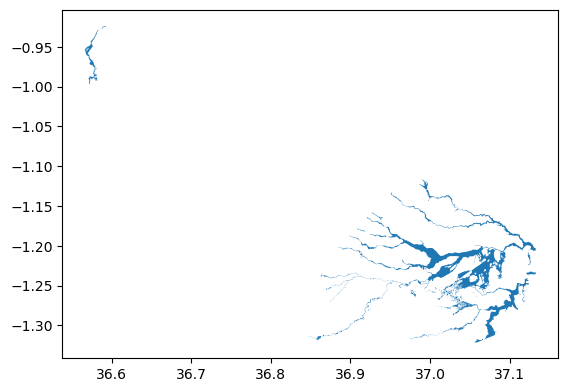

In [9]:
df_event_f.plot()

In [10]:
EXTERNAL_VAL_DATA_DIR = Path('../external_validation_data_db/')
EXTERNAL_VAL_DATA_DIR.mkdir(exist_ok=True, parents=True)

In [11]:
df_event_f.to_parquet(EXTERNAL_VAL_DATA_DIR / f'{event_dict["event_name"]}.parquet')

In [12]:
#df_event_f.to_file(EXTERNAL_VAL_DATA_DIR / f'{event_dict["event_name"]}.geojson', driver='GeoJSON')

# Extents

In [23]:
df_aoi_0 = gpd.read_file('../external_validation_data/unosat/mai_mahui_flood_and_landslides/FL20240426KEN_SHP/PL_20240501_AnalysisExtent_Nairobi_Kiambu.shp')[['geometry']] 

/var/folders/0p/d5x2m4tx5kg1246bplsvyfyh0000gq/T/ipykernel_32681/1814075783.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_aoi_1.geometry = df_aoi_1['geometry'].buffer(.001).envelope


<Axes: >

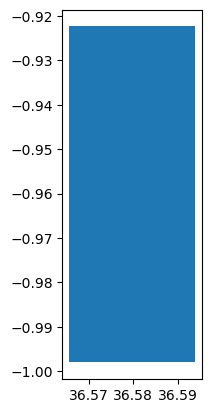

In [35]:
df_aoi_1 = gpd.read_file('../external_validation_data/unosat/mai_mahui_flood_and_landslides/FL20240426KEN_SHP/PL_20240501_LandslideMudslideExtent_MaiMahiu.shp')[['geometry']]
df_aoi_1.geometry = df_aoi_1['geometry'].buffer(.001).envelope
df_aoi_1.plot()

<Axes: >

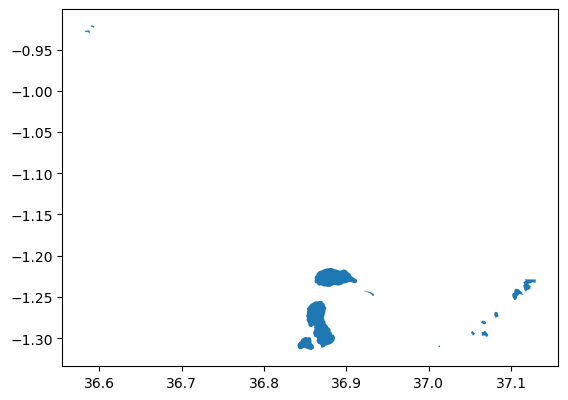

In [36]:
df_cloud_0 = gpd.read_file('../external_validation_data/unosat/mai_mahui_flood_and_landslides/FL20240426KEN_SHP/PL_20240501_CloudObstruction_Nairobi_Kiambu.shp')[['geometry']]
df_cloud_1 = gpd.read_file('../external_validation_data/unosat/mai_mahui_flood_and_landslides/FL20240426KEN_SHP/PL_20240501_CloudObstruction_MaiMahiu.shp')[['geometry']]
df_cloud = pd.concat([df_cloud_0, df_cloud_1], axis=0)
df_cloud.plot()

In [37]:
cloud_geo = df_cloud.geometry.unary_union

In [38]:
df_aoi = pd.concat([df_aoi_0, df_aoi_1], axis=0)
df_aoi.geometry = df_aoi.geometry.difference(cloud_geo)

<Axes: >

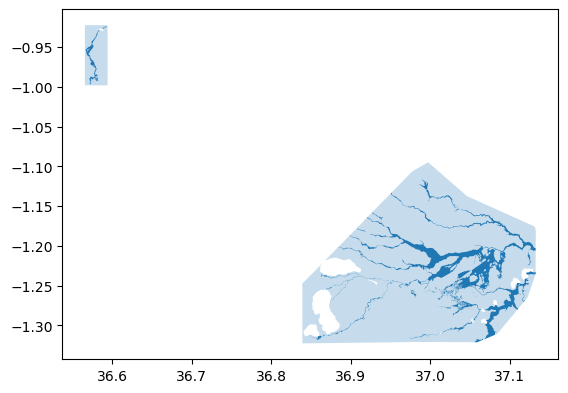

In [41]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
df_aoi.plot(ax=ax, alpha=.25)
df_event.plot(ax=ax)

In [42]:
EXTERNAL_VAL_EXTENTS = Path('../external_validation_data_extents_db/')
EXTERNAL_VAL_EXTENTS.mkdir(exist_ok=True, parents=True)

df_aoi.to_file(EXTERNAL_VAL_EXTENTS / f'{event_dict["event_name"]}.geojson', driver='GeoJSON')